<a href="https://colab.research.google.com/github/andreacangiani/NMPDE2025/blob/main/python/C6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Element Method in 1D - any order

Finite Element Method solver of any order $k$ for the 1D Poisson problem:

$-u''=f \quad \text{in } \Omega=(a,b)$

$u|_{\partial\Omega}=0$

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import sympy as sym

In [57]:
# Gauss quadrature formula on [0,1]
def quadrature(n_quadrature_points):

  # use numpy Gauss quadrature. This is defined in [-1,1]
  q, w = np.polynomial.legendre.leggauss(n_quadrature_points)

  return (q+1)/2, w/2

In [58]:
# The reference element is [0,1]. We construct the mappings, the determinant of their Jacobians, and the
# reference Basis functions
# by L. Heltai

def mapping(q, i):
    """
    Returns the mapping from [0,1] to T_k := [q[k], q[k+1]]
    """
    assert i < len(q)-1
    assert i >= 0
    return lambda x: q[i]+x*(q[i+1]-q[i])

def mapping_J(q,i):
    assert i < len(q)-1
    assert i >= 0
    return (q[i+1]-q[i])

def lagrange_basis(q, i):
    assert i < len(q)
    assert i >= 0
    return lambda x: np.prod([(x-q[j])/(q[i]-q[j]) for j in range(len(q)) if i!=j], axis=0)

# Workaround, to allow lambdify to work also on constant expressions
def np_lambdify(varname, func):
    lamb = sym.lambdify(varname, func, modules=['numpy'])
    if func.is_constant():
        return lambda t: np.full_like(t, lamb(t))
    else:
        return lambda t: lamb(np.array(t))

def lagrange_basis_derivative(q,i,order=1):
    t = sym.var('t')
    return np_lambdify(t, lagrange_basis(q,i)(t).diff(t,order))

In [59]:
def mesh(omega,N):

  return np.linspace(omega[0],omega[1],N+1)

FEM code any order

In [60]:
def FEM(omega,M,degree,n_qpoints,rhs):
  # 1D FEM with k=degree system matrix and rhs for
  # diffusion problem

  # Dimension of the problem
  N = M * degree +1

  # grid
  vertices = mesh(omega,M)

  # reference element (quadrature and Lagrange points)
  q, w = quadrature(n_qpoints)
  lagrange_points = np.linspace(0,1, degree+1)

  # Evaluation of Lagrange basis
  phi = np.array([lagrange_basis(lagrange_points,i)(q) for i in range(degree+1)]).T
  dphi = np.array([lagrange_basis_derivative(lagrange_points,i)(q) for i in range(degree+1)]).T

  # initialise system
  A = sp.lil_matrix((N,N))
  F = np.zeros(N)

  # Assembly loop
  for i in range(M):
    JxW = mapping_J(vertices, i) * w
    ele_A = np.einsum('qi,qj,q',dphi,dphi,JxW) / mapping_J(vertices,i)**2
    ele_F = np.einsum('qi,q,q',phi,rhs(mapping(vertices,i)(q)),JxW)

    # Assembly local-to-global
    j = i * degree
    m = j + degree + 1
    A[j:m,j:m] += ele_A
    F[j:m] += ele_F


  return A, F

Apply boundary conditions

In [61]:
def apply_boundary_conditions(omega,A, F, g):
  # Ideally should scale entries as those of A
  N = A.shape[0] - 1
  A[0,A[0].nonzero()] = 0; A[0,0] = 1;  F[0]=g(omega[0])
  A[N,A[N].nonzero()] = 0; A[N,N] = 1; F[N]=g(omega[1])

and solve

In [62]:
# Problem
omega = [0,np.pi]
rhs = lambda x: np.sin(x)
sol = lambda x: np.sin(x)

# degree of FEM basis
degree = 3

# Number of quadrature points
n_qpoints = 2*degree-1

# Number of experiments
no_experiments = 7

# Initialize
MM = np.zeros(no_experiments)
discrete_max_err = np.zeros(no_experiments)

# Solution loop
for i in range(no_experiments):
  M = 2**(i+2)
  MM[i] = M
  N = M*degree+1

  # call function computing FEM system
  A, F = FEM(omega,M,degree,n_qpoints,rhs)

  # and apply boundary conditions
  apply_boundary_conditions(omega,A, F, sol)

  # Solve the system
  Uh = sp.linalg.spsolve(A,F)

  # Compute exact solution
  x=np.linspace(omega[0],omega[1],N)
  U=sol(x)

  # Compute discrete max norm error
  discrete_max_err[i] = max(abs(U-Uh))

  # Compute H1 norm of I_h u - u_h


C:\Users\giako\AppData\Local\Temp\ipykernel_16976\116065037.py:32: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  Uh = sp.linalg.spsolve(A,F)


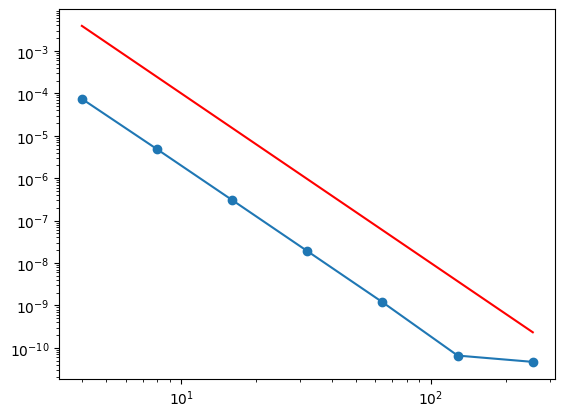

In [63]:
# Error loglog plots
plt.loglog(MM,discrete_max_err,'o-')
#plt.loglog(MM,interpola_H1_err**(1/2),'bd-')
plt.loglog(MM,MM**(-(degree+1)),'r')

In [64]:
print(MM)

[  4.   8.  16.  32.  64. 128. 256.]


**Exercise 1**: Write function computing $H^1$-norm error and test convergence for $k>1$.

In [65]:
def H1_interp_error(omega, M, degree, n_qpoints, Uh, exact_sol):
    """
    Computes || (I_h u - u_h)' ||_{L2(Ω)}
    where I_h u is the Lagrange interpolant of the exact solution.
    """

    # mesh and reference quadrature
    vertices = mesh(omega, M)
    q, w = quadrature(n_qpoints)
    lagrange_points = np.linspace(0, 1, degree+1)

    # basis derivatives on reference element
    dphi = np.array([
        lagrange_basis_derivative(lagrange_points, i)(q)
        for i in range(degree+1)
    ]).T

    # interpolate exact solution at global nodes
    x_nodes = mesh(omega, M * degree)
    Ih_u = exact_sol(x_nodes)

    err_sq = 0.0

    # loop over elements
    for i in range(M):
        J = mapping_J(vertices, i)

        # local DOFs
        j = i * degree
        m = j + degree + 1

        Ih_loc = Ih_u[j:m]
        Uh_loc = Uh[j:m]

        # derivative of interpolation and FEM solution
        Ih_dx = (dphi @ Ih_loc) / J
        Uh_dx = (dphi @ Uh_loc) / J

        # H1 seminorm contribution
        err_sq += np.sum((Ih_dx - Uh_dx)**2 * w * J)

    return np.sqrt(err_sq)


C:\Users\giako\AppData\Local\Temp\ipykernel_16976\3683643180.py:27: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  Uh = sp.linalg.spsolve(A, F)


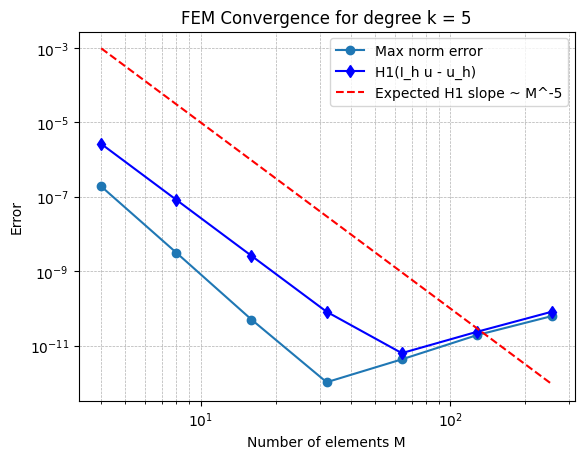

In [77]:
# Problem
omega = [0,np.pi]
rhs = lambda x: np.sin(x)
sol = lambda x: np.sin(x)

# degree of FEM basis
degree = 5

# Number of quadrature points
n_qpoints = 2*degree-1

# Number of experiments
no_experiments = 7

# Initialize
MM = np.zeros(no_experiments)
discrete_max_err = np.zeros(no_experiments)
interpola_H1_err = np.zeros(no_experiments)

for i in range(no_experiments):
    M = 2**(i+2)
    N = M*degree+1
    MM[i] = M

    A, F = FEM(omega, M, degree, n_qpoints, rhs)
    apply_boundary_conditions(omega, A, F, sol)
    Uh = sp.linalg.spsolve(A, F)

    interpola_H1_err[i] = H1_interp_error(omega, M, degree, n_qpoints, Uh, sol)


    # Compute exact solution
    x=np.linspace(omega[0],omega[1],N)
    U=sol(x)

    # Compute discrete max norm error
    discrete_max_err[i] = max(abs(U-Uh))


# Error loglog plots
plt.loglog(MM, discrete_max_err, 'o-', label='Max norm error')
plt.loglog(MM, interpola_H1_err, 'bd-', label='H1(I_h u - u_h)')
plt.loglog(MM, MM**(-degree), 'r--', label=f'Expected H1 slope ~ M^-{degree}')
plt.xlabel('Number of elements M')
plt.ylabel('Error')
plt.title(f'FEM Convergence for degree k = {degree}')
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()